# Car Detection using Simplified YOLO Architecture

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/data')

Mounted at /content/drive


## 1. Data Exploration and Visualization

Load the training dataset and visualize sample images with their bounding box annotations to understand the data structure.

Training annotations:
             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422


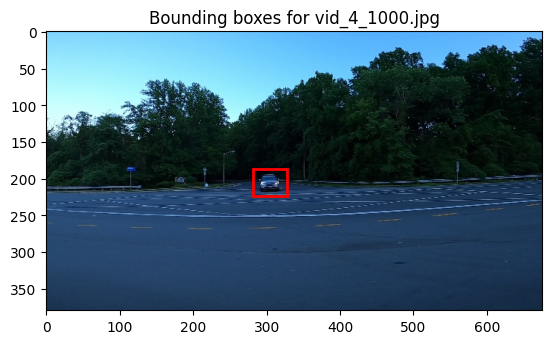

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

# Define paths to image folders and CSV files
train_img_dir = "training_images"
test_img_dir = "testing_images"
train_csv = "train_solution_bounding_boxes.csv"
sample_csv = "sample_submission.csv"

# Load training annotations from CSV
train_df = pd.read_csv(train_csv)
print("Training annotations:")
print(train_df.head())

# Select first image from training data
sample_row = train_df.iloc[0]
img_name = sample_row["image"]
img_path = os.path.join(train_img_dir, img_name)

# Load and display image
image = Image.open(img_path)

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(image)

# Get all bounding boxes for this image
boxes = train_df[train_df["image"] == img_name]

# Draw each bounding box on the image
for _, row in boxes.iterrows():
    xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                             linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)

plt.title(f"Bounding boxes for {img_name}")
plt.show()

## 2. Model Architecture

Build a simplified YOLO-inspired CNN model for single car detection. The model uses three convolutional blocks followed by dense layers to predict bounding box coordinates (x, y, width, height) and confidence score.

In [3]:
from tensorflow.keras import layers, Model

def build_yolov3_tiny(num_classes=1):
    """Build simplified YOLO model for car detection"""
    # Input layer - accepts 416x416 RGB images
    inputs = layers.Input(shape=(416, 416, 3))

    # First convolutional block
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2, 2)(x)

    # Second convolutional block
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Third convolutional block
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer: predicts 5 values (x, y, width, height, confidence)
    outputs = layers.Dense(num_classes * 5, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Build model with 1 class (car)
model = build_yolov3_tiny(num_classes=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 416, 416, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 208, 208, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,175,525 (84.59 MB)

 Trainable params: 22,175,525 (84.59 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Data Preparation and Preprocessing

Prepare training data by:
- Grouping multiple bounding boxes per image.
- Normalizing coordinates based on original image dimensions.
- Selecting the first car from each image for single-object detection.
- Creating TensorFlow dataset with batch processing.

In [4]:
from PIL import Image
import tensorflow as tf

# Group all bounding boxes by image name
grouped_data = {}

for _, row in train_df.iterrows():
    img_name = row['image']
    img_path = os.path.join(train_img_dir, img_name)

    if img_name not in grouped_data:
        # Get original image dimensions
        orig_img = Image.open(img_path)
        orig_width, orig_height = orig_img.size
        grouped_data[img_name] = {
            'path': img_path,
            'width': orig_width,
            'height': orig_height,
            'boxes': []
        }

    # Normalize bounding box coordinates by original image size
    x_center = ((row['xmin'] + row['xmax']) / 2) / grouped_data[img_name]['width']
    y_center = ((row['ymin'] + row['ymax']) / 2) / grouped_data[img_name]['height']
    width = (row['xmax'] - row['xmin']) / grouped_data[img_name]['width']
    height = (row['ymax'] - row['ymin']) / grouped_data[img_name]['height']

    bbox = [x_center, y_center, width, height, 1.0]
    grouped_data[img_name]['boxes'].append(bbox)

print(f"Prepared {len(grouped_data)} unique images with annotations")
print(f"Total bounding boxes: {sum(len(v['boxes']) for v in grouped_data.values())}")

# Use only first bounding box per image for single car detection
your_training_data = [(v['path'], v['boxes'][0]) for v in grouped_data.values()]

print(f"Training on {len(your_training_data)} images (one car per image)")


def data_generator():
    for img_path, bbox in your_training_data:
        # Load image from file
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)

        # Resize to 416x416 and normalize pixel values to 0-1
        img = tf.image.resize(img, (416, 416))
        img = tf.cast(img, tf.float32) / 255.0

        # Convert bounding box to tensor format
        bbox = tf.convert_to_tensor(bbox, dtype=tf.float32)
        bbox = tf.RaggedTensor.from_tensor(tf.expand_dims(bbox, axis=0))

        yield img, bbox


# Create tensorflow dataset with batch size 8
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(416, 416, 3), dtype=tf.float32),
        tf.RaggedTensorSpec(shape=(None, 5), dtype=tf.float32)
    )
).batch(8).repeat().prefetch(tf.data.AUTOTUNE)

Prepared 355 unique images with annotations
Total bounding boxes: 559
Training on 355 images (one car per image)


## 4. Model Training - Phase 1 (Epochs 1-15)

Compile and train the model using:
- Adam optimizer with learning rate 0.0001.
- Mean Squared Error loss function.
- Batch size of 8 images.
- Model checkpoints saved after each epoch.

In [ ]:
# Define loss function for training
def yolo_loss(y_true, y_pred):
    # Calculate Mean Squared Error between predicted and actual values
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

# Function to convert ragged tensor to dense tensor
def convert_ragged_to_dense(img, label):
    # Convert label from ragged format to dense format
    label_dense = label.to_tensor(default_value=0.0)
    # Take only first bounding box from each image
    label_first = label_dense[0]
    return img, label_first

# Apply preprocessing to dataset
train_dataset_processed = train_dataset.unbatch().map(convert_ragged_to_dense).batch(8).prefetch(tf.data.AUTOTUNE)

# Build model architecture
from tensorflow.keras import layers, Model

def build_yolov3_tiny(num_classes=1):
    """Build simplified model for car detection"""
    # Input layer
    inputs = layers.Input(shape=(416, 416, 3))

    # Convolutional layers with pooling
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Output layer: 5 values per class
    outputs = layers.Dense(num_classes * 5, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Create model instance
model = build_yolov3_tiny(num_classes=1)

# Compile model with optimizer and loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=yolo_loss
)

print("Model compiled successfully.")

# Create directory to save model checkpoints
checkpoint_dir = "checkpoints/yolo_car_detector"
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup callback to save model weights after each epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

# Calculate number of steps per epoch
steps_per_epoch = len(your_training_data) // 8

# Train the model
history = model.fit(
    train_dataset_processed,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    callbacks=[checkpoint_callback]
)

print(f"Training completed: {steps_per_epoch} steps per epoch, 15 epochs total")

## 5. Model Training - Phase 2 (Epochs 16-25)

Continue training from epoch 15 to observe model behavior over extended training. This helps identify the optimal checkpoint before overfitting occurs.

In [ ]:
# Load weights from epoch 15 to continue training
model.load_weights("checkpoints/yolo_car_detector/model_epoch_15.weights.h5")
print("Loaded epoch 15 weights")

# Calculate steps per epoch
steps_per_epoch = len(your_training_data) // 8

# Continue training from epoch 15 to epoch 25
history = model.fit(
    train_dataset_processed,
    steps_per_epoch=steps_per_epoch,
    initial_epoch=15,
    epochs=25,
    callbacks=[checkpoint_callback]
)

print("Extended training completed: epochs 16-25")

## 6. Evaluation Helper Functions

Define utility functions for:
- Converting normalized predictions to pixel coordinates.
- Calculating Intersection over Union (IoU) between predicted and ground truth boxes.
- Visualizing predictions with bounding boxes.

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

IMG_SIZE = 416

def pred_to_xyxy(pred, orig_w, orig_h):
    """
    Convert normalized prediction to pixel coordinates on original image.
    Input: [x_center, y_center, width, height, confidence]
    Output: [xmin, ymin, xmax, ymax, confidence]
    """
    x_c, y_c, w, h, conf = pred

    # Convert normalized values to pixel coordinates in 416x416 space
    x_c_px = x_c * IMG_SIZE
    y_c_px = y_c * IMG_SIZE
    w_px = w * IMG_SIZE
    h_px = h * IMG_SIZE

    # Convert center coordinates to corner coordinates
    xmin_416 = x_c_px - w_px/2
    ymin_416 = y_c_px - h_px/2
    xmax_416 = x_c_px + w_px/2
    ymax_416 = y_c_px + h_px/2

    # Scale from 416x416 to original image size
    sx = orig_w / IMG_SIZE
    sy = orig_h / IMG_SIZE
    xmin = xmin_416 * sx
    ymin = ymin_416 * sy
    xmax = xmax_416 * sx
    ymax = ymax_416 * sy

    # Ensure coordinates are within image bounds
    return [max(0, xmin), max(0, ymin), min(orig_w, xmax), min(orig_h, ymax), conf]

def xyxy_to_xywh_norm_from_csv(bbox, orig_w, orig_h):
    """Convert pixel bbox coordinates to normalized center format"""
    xmin, ymin, xmax, ymax = bbox

    # Calculate center coordinates and dimensions
    cx = (xmin + xmax) / 2.0
    cy = (ymin + ymax) / 2.0
    w = (xmax - xmin)
    h = (ymax - ymin)

    # Normalize to 416x416 reference
    cx_416 = cx * (IMG_SIZE / orig_w)
    cy_416 = cy * (IMG_SIZE / orig_h)
    w_416 = w * (IMG_SIZE / orig_w)
    h_416 = h * (IMG_SIZE / orig_h)

    return [cx_416/IMG_SIZE, cy_416/IMG_SIZE, w_416/IMG_SIZE, h_416/IMG_SIZE]

def iou_xyxy(boxA, boxB):
    """Calculate Intersection over Union between two boxes"""
    # Find intersection coordinates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate intersection area
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    # Calculate union area
    boxAArea = max(0, (boxA[2]-boxA[0])) * max(0, (boxA[3]-boxA[1]))
    boxBArea = max(0, (boxB[2]-boxB[0])) * max(0, (boxB[3]-boxB[1]))

    if boxAArea + boxBArea - interArea == 0:
        return 0.0

    return interArea / (boxAArea + boxBArea - interArea)

def draw_prediction(img_path, pred_xyxy, gt_xyxy=None, title=None):
    """Visualize predicted and ground truth bounding boxes"""
    img = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.imshow(img)

    # Draw predicted box in red
    xmin, ymin, xmax, ymax, conf = pred_xyxy
    rect = patches.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, max(0,ymin-6), f"Pred: {conf:.2f}",
            color='r', fontsize=10, backgroundcolor='white')

    # Draw ground truth box in green if provided
    if gt_xyxy is not None:
        gxmin, gymin, gxmax, gymax = gt_xyxy
        rect2 = patches.Rectangle((gxmin,gymin), gxmax-gxmin, gymax-gymin,
                                  linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect2)
        ax.text(gxmin, max(0,gymin-18), "GT",
                color='g', fontsize=10, backgroundcolor='white')

    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

## 7. Model Evaluation

Evaluate model performance on training images by:
- Loading the best model checkpoint (epoch 15).
- Calculating IoU for each prediction.
- Counting True Positives (IoU > 0.5) and False Positives.
- Displaying debug information for sample images.

**Note:** Test images lack ground truth annotations, so evaluation is performed on training data.

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Define paths to CSV files
test_csv_path = "sample_submission.csv"
train_csv_path = "train_solution_bounding_boxes.csv"

# Check which dataset to use for evaluation
if os.path.exists(test_csv_path):
    df_test = pd.read_csv(test_csv_path)
    if "bounds" in df_test.columns and df_test["bounds"].str.contains("0.0").all():
        print("Detected sample_submission.csv with placeholder values - using training CSV for evaluation.")
        test_csv_path = train_csv_path
        test_dir = "training_images"
    else:
        print("Using test CSV for evaluation.")
        test_dir = "testing_images"
else:
    print("Test CSV not found - using training CSV for evaluation.")
    test_csv_path = train_csv_path
    test_dir = "training_images"

# Load CSV file for evaluation
test_df = pd.read_csv(test_csv_path)
print(f"Loaded CSV from: {test_csv_path}")
print(f"Evaluating images from: {test_dir}")

# Display CSV structure
print("\nCSV columns:", test_df.columns.tolist())
print("First row sample:")
print(test_df.iloc[0])

# Load trained model weights
model.load_weights("checkpoints/yolo_car_detector/model_epoch_15.weights.h5")
print("Model weights loaded successfully.\n")

# Initialize evaluation metrics
tp, fp, fn = 0, 0, 0

# Evaluate model on all images
for idx, row in test_df.iterrows():
    img_path = os.path.join(test_dir, row["image"])
    if not os.path.exists(img_path):
        continue

    # Load original image
    orig_img = Image.open(img_path)
    orig_w, orig_h = orig_img.size

    # Preprocess image for model
    img = orig_img.resize((416, 416))
    x = np.array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    # Get model prediction
    preds = model.predict(x, verbose=0)[0]
    pred_xyxy = pred_to_xyxy(preds, orig_w, orig_h)

    # Print debug information for first 3 images
    if idx < 3:
        print(f"\n--- Image {idx}: {row['image']} (size: {orig_w}x{orig_h}) ---")
        print(f"Raw model output: {preds}")
        print(f"Predicted bbox: {pred_xyxy}")

    # Get ground truth bounding box
    if 'xmin' in test_df.columns:
        gt_xyxy = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]

        if idx < 3:
            print(f"Ground truth bbox: {gt_xyxy}")

        # Calculate IoU
        iou = iou_xyxy(pred_xyxy[:4], gt_xyxy)

        if idx < 3:
            print(f"IoU: {iou:.4f}")

        # Count true positives and false positives
        if iou > 0.5:
            tp += 1
        else:
            fp += 1
    else:
        # Handle bounds column format
        try:
            bbox_values = [float(x) for x in row["bounds"].split()]
            if len(bbox_values) >= 4:
                gt_xyxy = [bbox_values[0] * orig_w,
                           bbox_values[1] * orig_h,
                           bbox_values[2] * orig_w,
                           bbox_values[3] * orig_h]

                if idx < 3:
                    print(f"Ground truth bbox: {gt_xyxy}")

                iou = iou_xyxy(pred_xyxy[:4], gt_xyxy)

                if idx < 3:
                    print(f"IoU: {iou:.4f}")

                if iou > 0.5:
                    tp += 1
                else:
                    fp += 1
            else:
                fn += 1
        except Exception as e:
            if idx < 3:
                print(f"Error parsing ground truth: {e}")
            fn += 1

# Print evaluation results
print("\n")
print(f"Evaluation completed on first 3 images (debug mode).")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Detected sample_submission.csv with placeholder values - using training CSV for evaluation.
Loaded CSV from: train_solution_bounding_boxes.csv
Evaluating images from: training_images

CSV columns: ['image', 'xmin', 'ymin', 'xmax', 'ymax']
First row sample:
image    vid_4_1000.jpg
xmin         281.259045
ymin         187.035071
xmax         327.727931
ymax         223.225547
Name: 0, dtype: object
Model weights loaded successfully.


--- Image 0: vid_4_1000.jpg (size: 676x380) ---
Raw model output: [0.54378015 0.58779013 0.10360905 0.10473071 0.9945654 ]
Predicted bbox: [np.float32(332.57553), np.float32(203.46143), np.float32(402.61523), np.float32(243.2591), np.float32(0.9945654)]
Ground truth bbox: [281.2590449, 187.0350708, 327.7279305, 223.225547]
IoU: 0.0000

--- Image 1: vid_4_10000.jpg (size: 676x380) ---
Raw model output: [0.15451494 0.5668651  0.16269457 0.13630371 0.9830112 ]
Predicted bbox: [np.float32(49.461334), np.float32(189.51103), np.float32(159.44286), np.float32(241.

## 8. Prediction Visualization

Visualize model predictions on random sample images. Red boxes show predicted bounding boxes, green boxes show ground truth annotations. IoU scores indicate prediction accuracy.

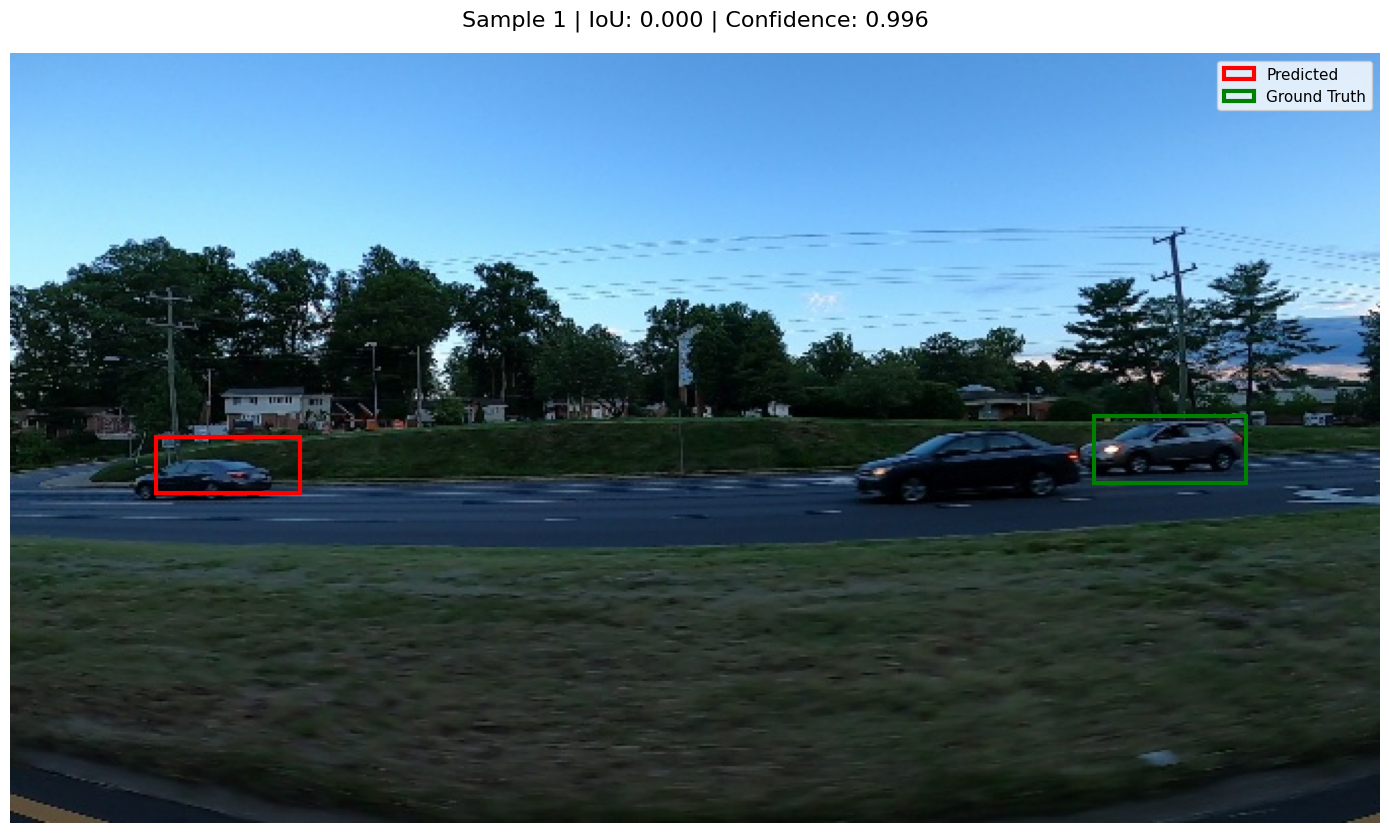

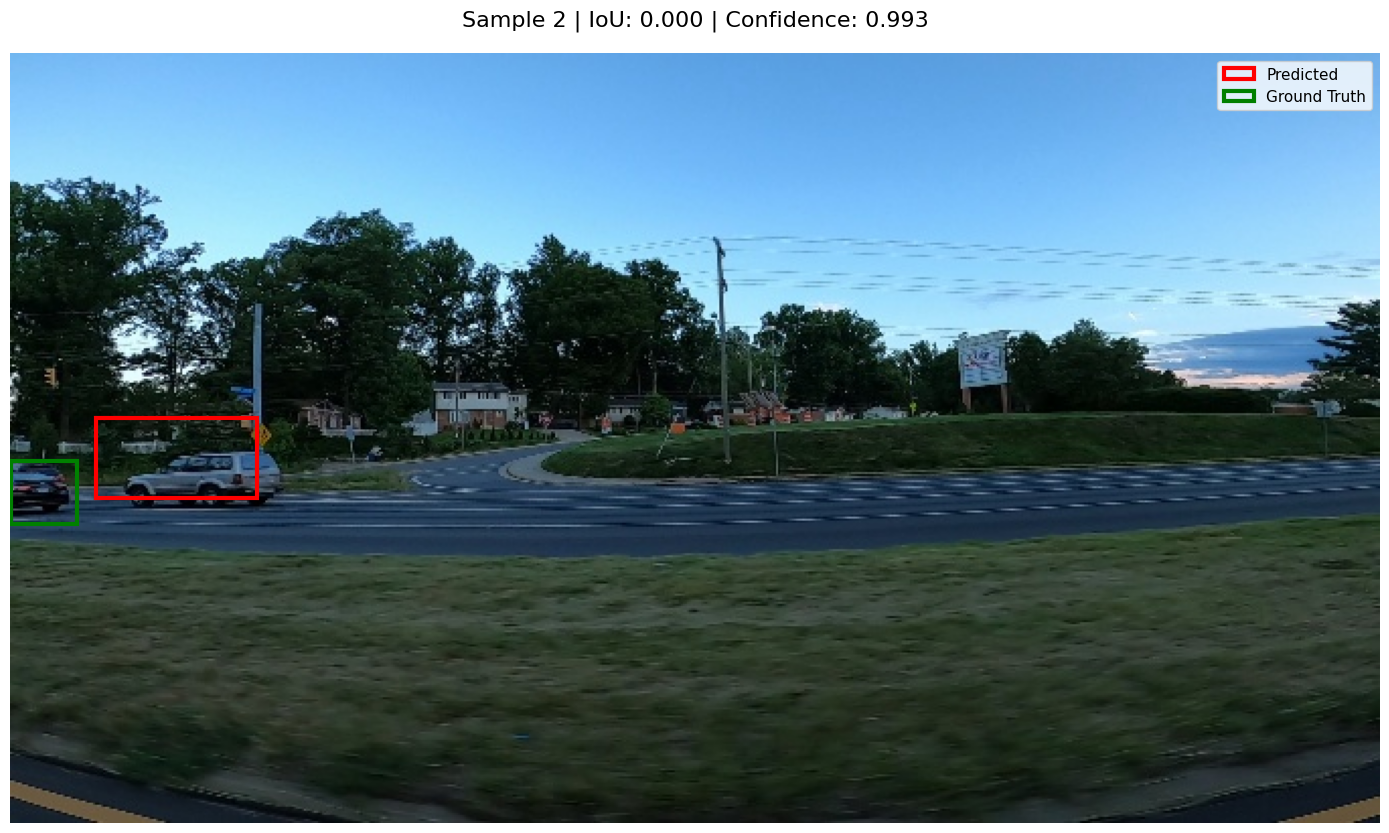

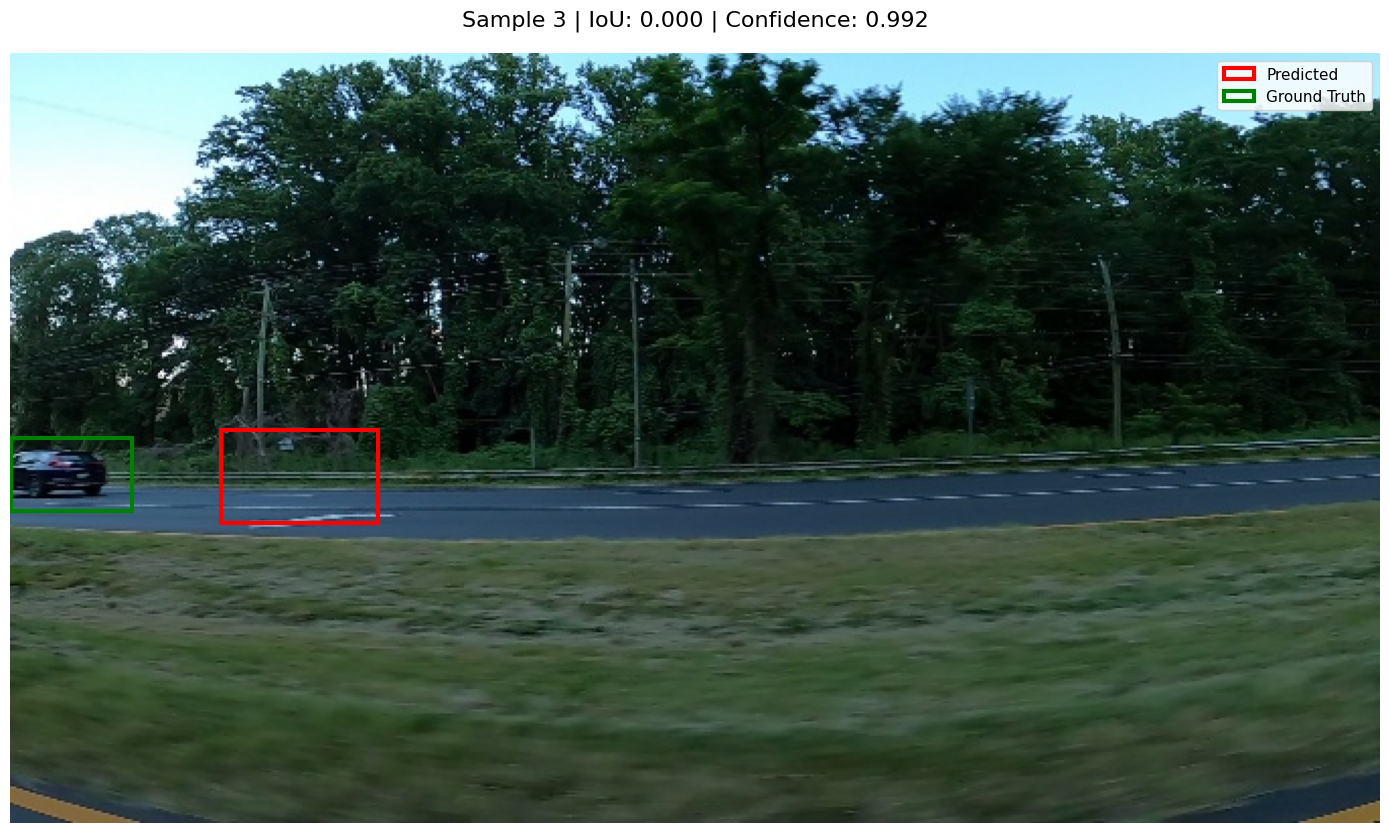

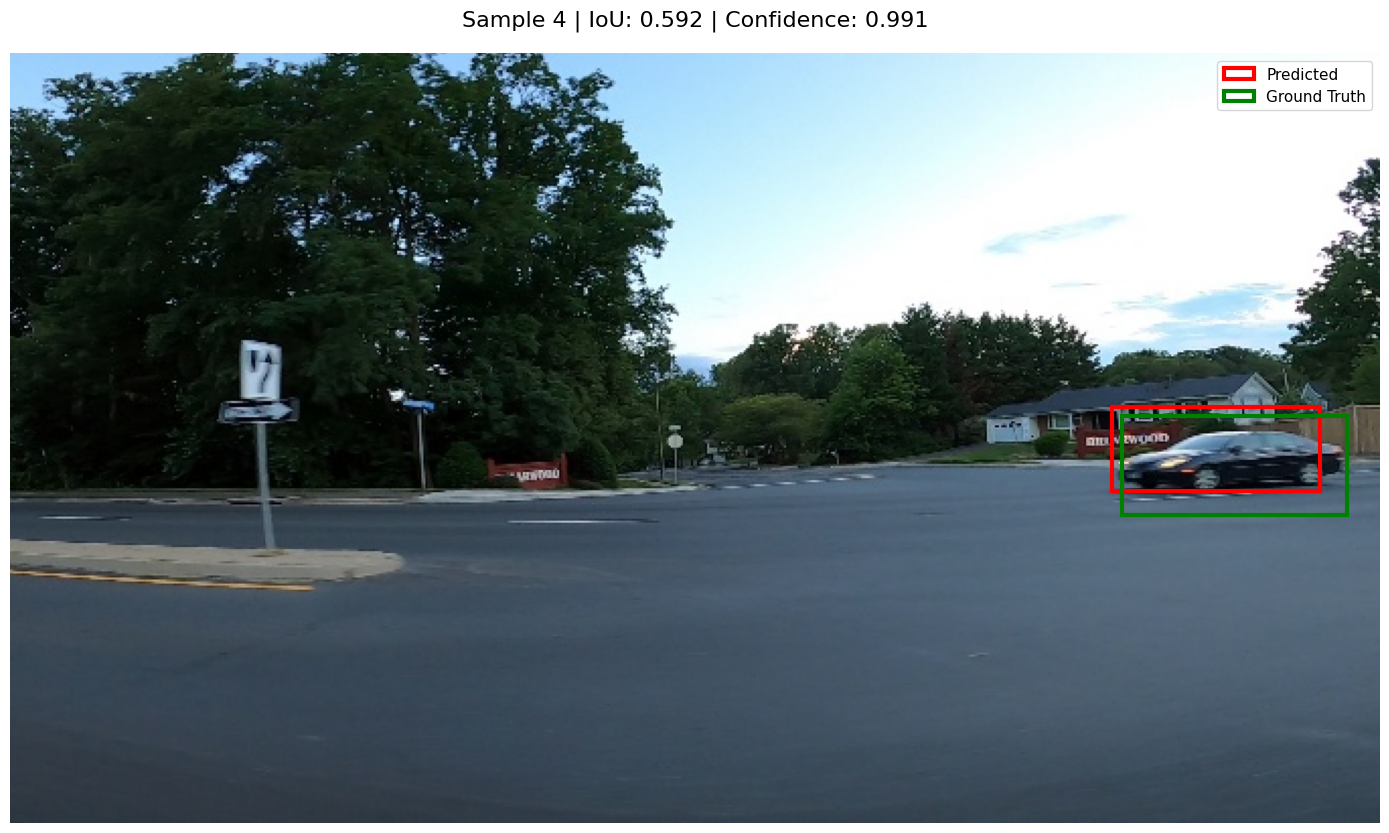

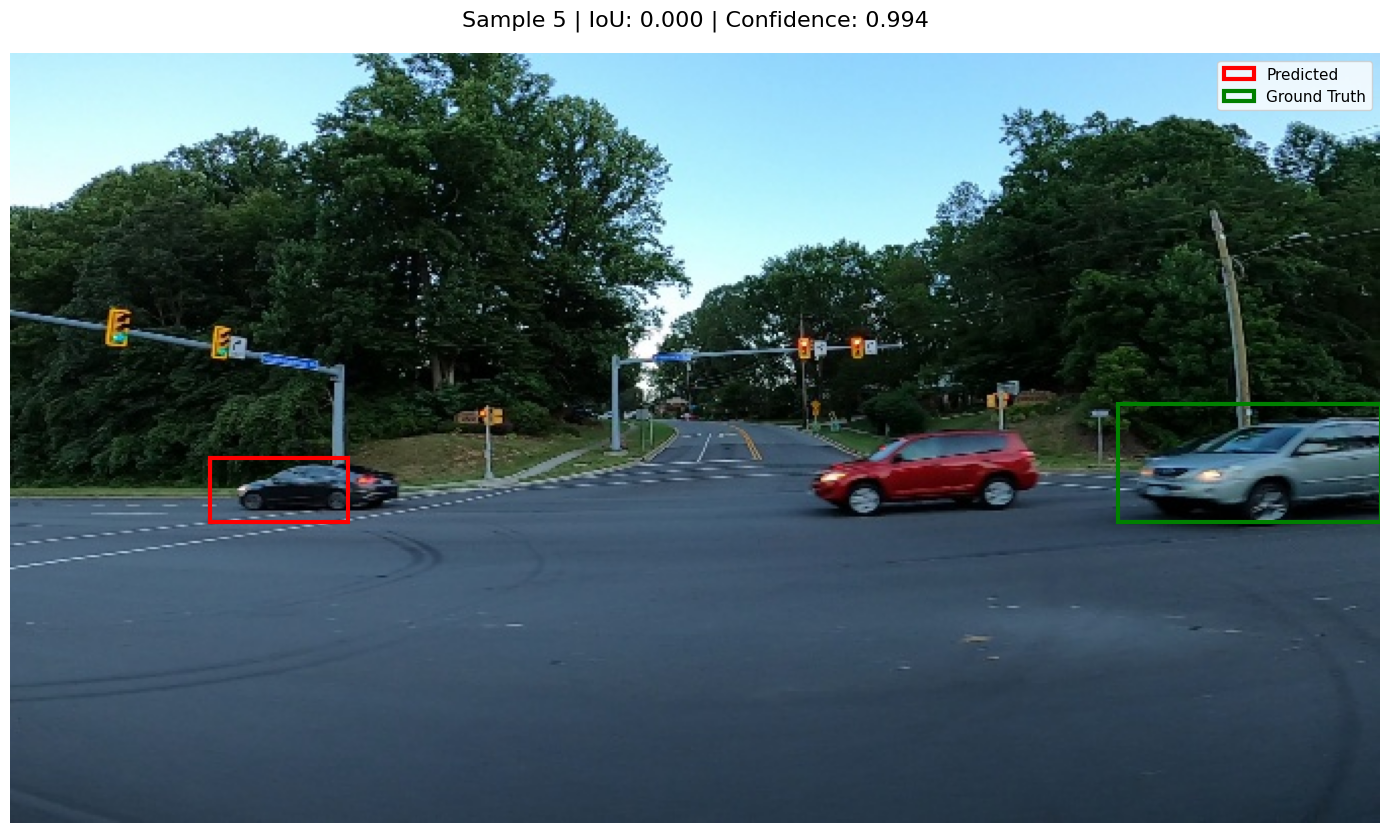

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

# Select 5 random images for visualization
sample_indices = random.sample(range(len(test_df)), 5)

# Visualize each image individually
for i, idx in enumerate(sample_indices):
    row = test_df.iloc[idx]
    img_path = os.path.join(test_dir, row["image"])

    # Load and preprocess image
    orig_img = Image.open(img_path)
    orig_w, orig_h = orig_img.size
    img = orig_img.resize((416, 416))
    x = np.array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    # Get prediction
    preds = model.predict(x, verbose=0)[0]
    pred_xyxy = pred_to_xyxy(preds, orig_w, orig_h)

    # Get ground truth
    gt_xyxy = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    iou = iou_xyxy(pred_xyxy[:4], gt_xyxy)

    # Create individual plot
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.imshow(orig_img)

    # Draw predicted bounding box in red
    pred_rect = patches.Rectangle(
        (pred_xyxy[0], pred_xyxy[1]),
        pred_xyxy[2]-pred_xyxy[0],
        pred_xyxy[3]-pred_xyxy[1],
        linewidth=3, edgecolor='red', facecolor='none', label='Predicted'
    )
    ax.add_patch(pred_rect)

    # Draw ground truth bounding box in green
    gt_rect = patches.Rectangle(
        (gt_xyxy[0], gt_xyxy[1]),
        gt_xyxy[2]-gt_xyxy[0],
        gt_xyxy[3]-gt_xyxy[1],
        linewidth=3, edgecolor='green', facecolor='none', label='Ground Truth'
    )
    ax.add_patch(gt_rect)

    # Add title with IoU and confidence score
    ax.set_title(f"Sample {i+1} | IoU: {iou:.3f} | Confidence: {pred_xyxy[4]:.3f}", fontsize=16, pad=20)
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=11)

    plt.tight_layout()
    plt.show()